In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import folium
from IPython.display import display, HTML
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from shapely.geometry import shape
import json

In [2]:
df=pd.read_excel('https://raw.githubusercontent.com/BiancaDiFranco/M-todosOP/main/Trabajo%20final/Rosario%20F.xlsx', engine='openpyxl')
secciones=gpd.read_file('https://github.com/BiancaDiFranco/M-todosOP/raw/refs/heads/main/Trabajo%20final/datasets%20complementarios/secciones_catastrales.gml')
distritos=gpd.read_file('https://github.com/BiancaDiFranco/M-todosOP/raw/refs/heads/main/Trabajo%20final/datasets%20complementarios/distritos_descentralizados.gml')
barrios=gpd.read_file('https://github.com/BiancaDiFranco/M-todosOP/raw/refs/heads/main/Trabajo%20final/datasets%20complementarios/barrios.gml')
estratos=gpd.read_file('https://github.com/BiancaDiFranco/M-todosOP/raw/refs/heads/main/Trabajo%20final/datasets%20complementarios/poblaciones/Estratificaci%C3%B3n%20de%20radios%20censales%20-%20Rosario.csv')
niveleducativo=gpd.read_file('https://github.com/BiancaDiFranco/M-todosOP/raw/refs/heads/main/Trabajo%20final/datasets%20complementarios/poblaciones/Indicadores%20de%20personas.%20Radios,%202022%20-%20Rosario.csv')

In [3]:
geometry = [Point(xy) for xy in zip(df['Coord1__Longitude'], df['Coord1__Latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)
gdf.set_crs('EPSG:4326', inplace=True)
union=gpd.sjoin(gdf, barrios, how='inner', predicate='within')
unionseccion=gpd.sjoin(gdf, secciones, how='inner', predicate='within')
uniondistritos=gpd.sjoin(gdf, distritos, how='inner', predicate='within')

In [4]:
colores_partidos = {
    'LIBERTARIOS': '#BF00BF',
    'FdT': '#00BFBF',
    'OTROS': '#ADFF2F',
    'NINGUNO/NOSABE': '#696969',
    'JxC': '#F2CB07',
    'PNK': '#483D8B',
    'FIT': '#8B0000',
}

In [5]:
gdf['color']=gdf['INT DE VOTO X ESPACIO'].map(colores_partidos).fillna('black')

In [6]:
#Filtrado de datos para Rosario
lat_min_valid = -33.0
lat_max_valid = -32.85
lon_min_valid = -60.790
lon_max_valid = -60.6
gdf = gdf[
    (gdf['Coord1__Latitude'] >= lat_min_valid) &
    (gdf['Coord1__Latitude'] <= lat_max_valid) &
    (gdf['Coord1__Longitude'] >= lon_min_valid) &
    (gdf['Coord1__Longitude'] <= lon_max_valid)
]

In [7]:
m = folium.Map(location=[-32.9, -60.7], zoom_start=13)
for _, row in gdf.iterrows():
    folium.Marker(
        location=[row['Coord1__Latitude'], row['Coord1__Longitude']],
        popup=(
            f"EDAD: {row['EDAD']}<br>"
            f"GENERO: {row['GENERO']}<br>"
            f"INT DE VOTO: {row['INT DE VOTO X ESPACIO']}<br>"
            f"RADIO: {row['RADIO']}"
        )
    ).add_to(m)

map_path = "Rosario_Mapa.html"
m.save(map_path)
map_html = m._repr_html_()
display(HTML(map_html))

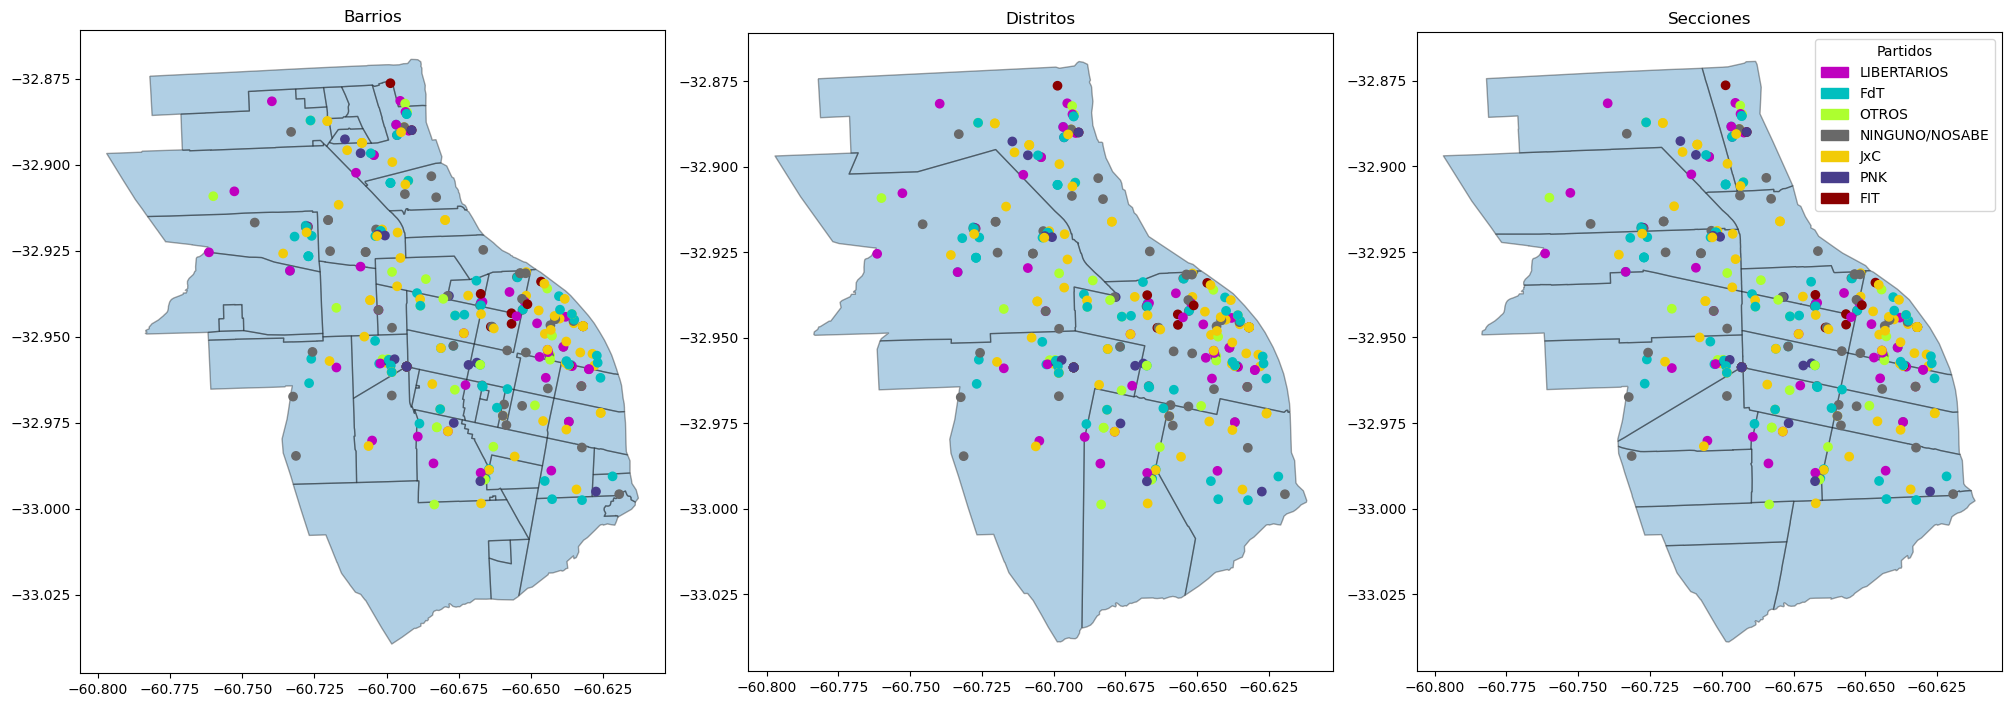

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10), constrained_layout=True)
base = barrios.plot(figsize=(20, 20), alpha=0.35, edgecolor='k', ax=axes[0])
gdf.plot(ax=base, color=gdf['color'])
axes[0].set_title('Barrios')
base = distritos.plot(figsize=(20, 20), alpha=0.35, edgecolor='k', ax=axes[1])
gdf.plot(ax=base, color=gdf['color'])
axes[1].set_title('Distritos')
base = secciones.plot(figsize=(20, 20), alpha=0.35, edgecolor='k', ax=axes[2])
gdf.plot(ax=base, legend=True, color=gdf['color'])
axes[2].set_title('Secciones')
leyenda = [mpatches.Patch(color=color, label=partido) for partido, color in colores_partidos.items()]

plt.legend(handles=leyenda, title='Partidos', loc='upper right', fontsize=10)
plt.show()


In [9]:
conteo_votos = (
    union.groupby(['BARRIO', 'INT DE VOTO X ESPACIO'])
    .size()
    .reset_index(name='conteo')
)
mayor_votos_por_barrio = conteo_votos.loc[conteo_votos.groupby('BARRIO')['conteo'].idxmax()]
barrios = barrios.merge(mayor_votos_por_barrio, on='BARRIO', how='left')
barrios['color'] = barrios['INT DE VOTO X ESPACIO'].map(colores_partidos).fillna('black')
conteo_votos_por_barrio = (
    union.groupby('BARRIO')
    .size()
    .reset_index(name='cantidad_votos')
)
barrios = barrios.merge(conteo_votos_por_barrio, on='BARRIO', how='left')

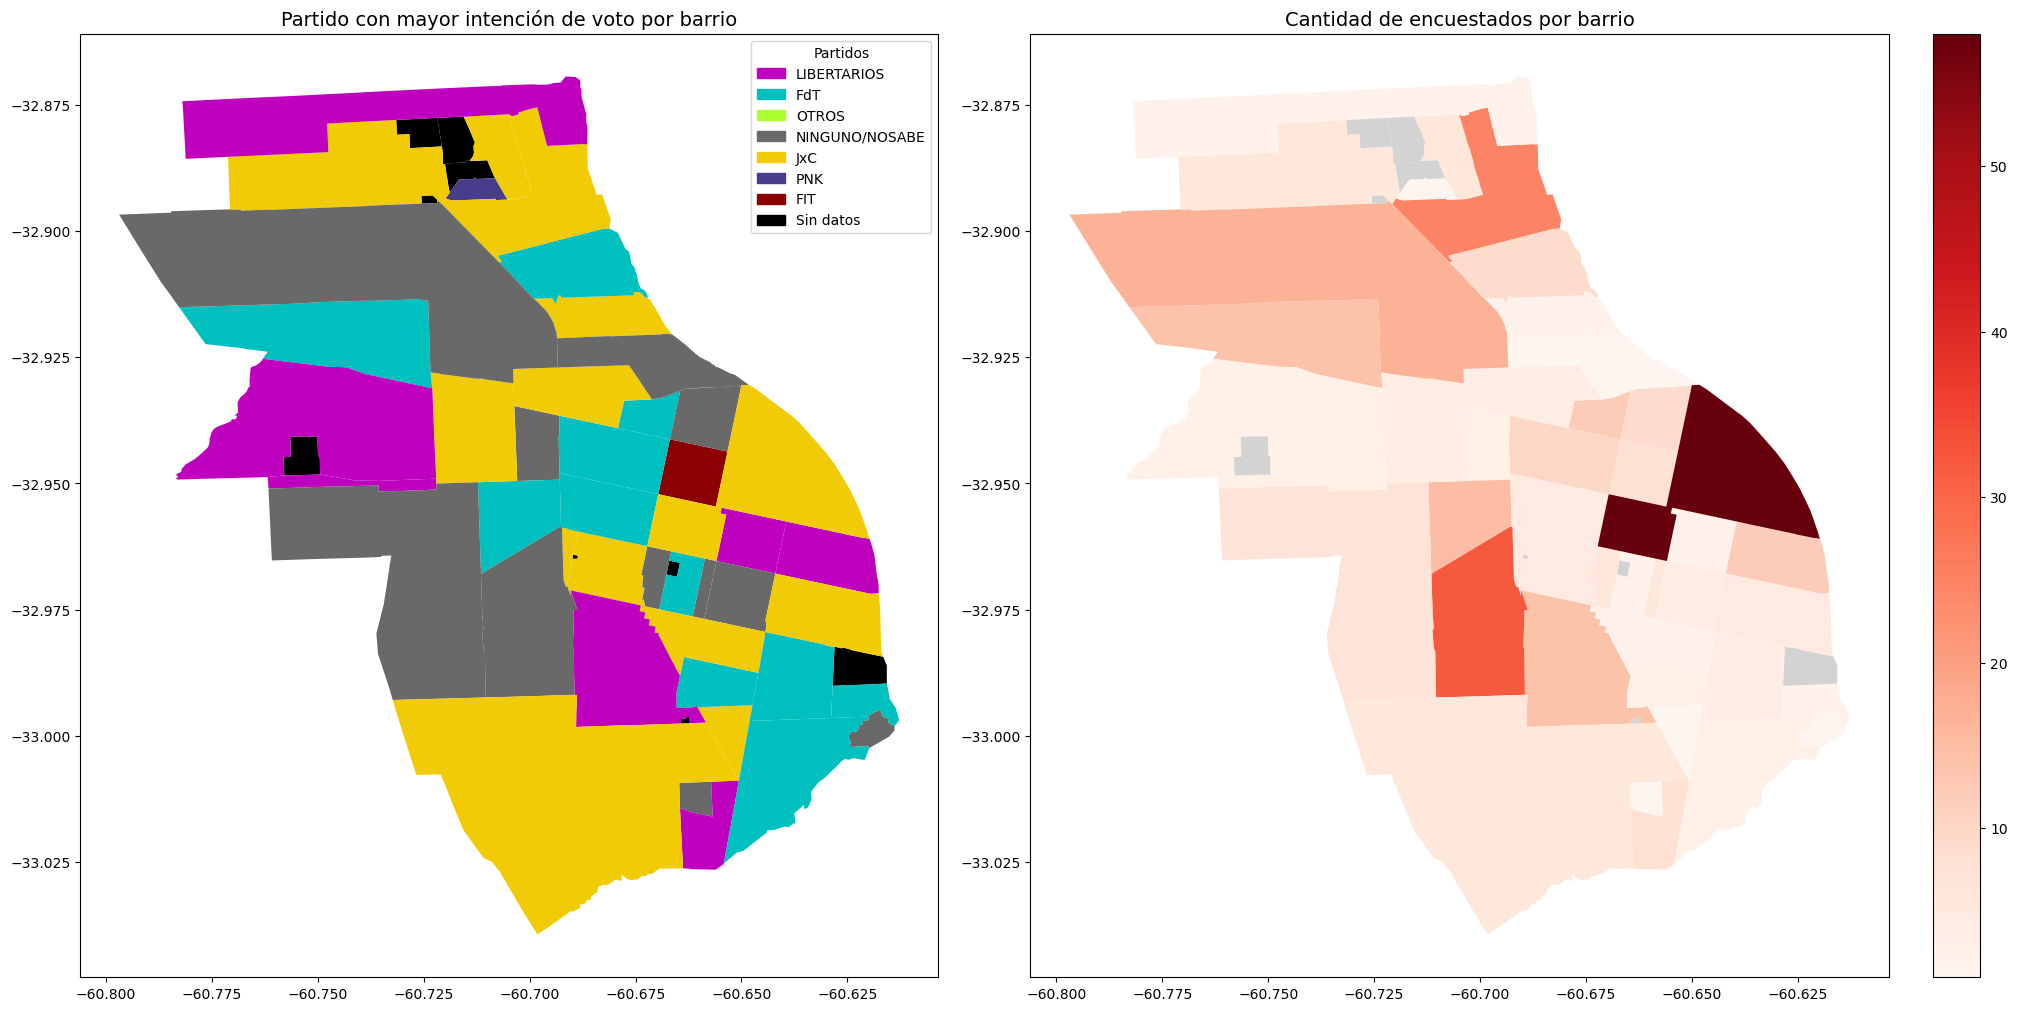

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10), constrained_layout=True)
barrios.plot(color=barrios['color'], ax=axes[0])
axes[0].set_title('Partido con mayor intención de voto por barrio', fontsize=14)
leyenda = [mpatches.Patch(color=color, label=partido) for partido, color in colores_partidos.items()]
leyenda.append(mpatches.Patch(color='black', label='Sin datos'))
axes[0].legend(handles=leyenda, title='Partidos', loc='upper right', fontsize=10)
barrios.plot(
    column='cantidad_votos', 
    cmap='Reds', 
    legend=True, 
    ax=axes[1],
    missing_kwds={
        "color": "lightgrey",
    }
)
axes[1].set_title('Cantidad de encuestados por barrio', fontsize=14)
plt.show()

In [11]:
conteo_votos = (
    uniondistritos.groupby(['DISTRITO', 'INT DE VOTO X ESPACIO'])
    .size()
    .reset_index(name='conteo')
)
mayor_votos_por_distrito = conteo_votos.loc[conteo_votos.groupby('DISTRITO')['conteo'].idxmax()]
distritos = distritos.merge(mayor_votos_por_distrito, on='DISTRITO', how='left')
distritos['color'] = distritos['INT DE VOTO X ESPACIO'].map(colores_partidos).fillna('black')
conteo_votos_por_distrito = (
    uniondistritos.groupby('DISTRITO')
    .size()
    .reset_index(name='cantidad_votos')
)
distritos = distritos.merge(conteo_votos_por_distrito, on='DISTRITO', how='left')

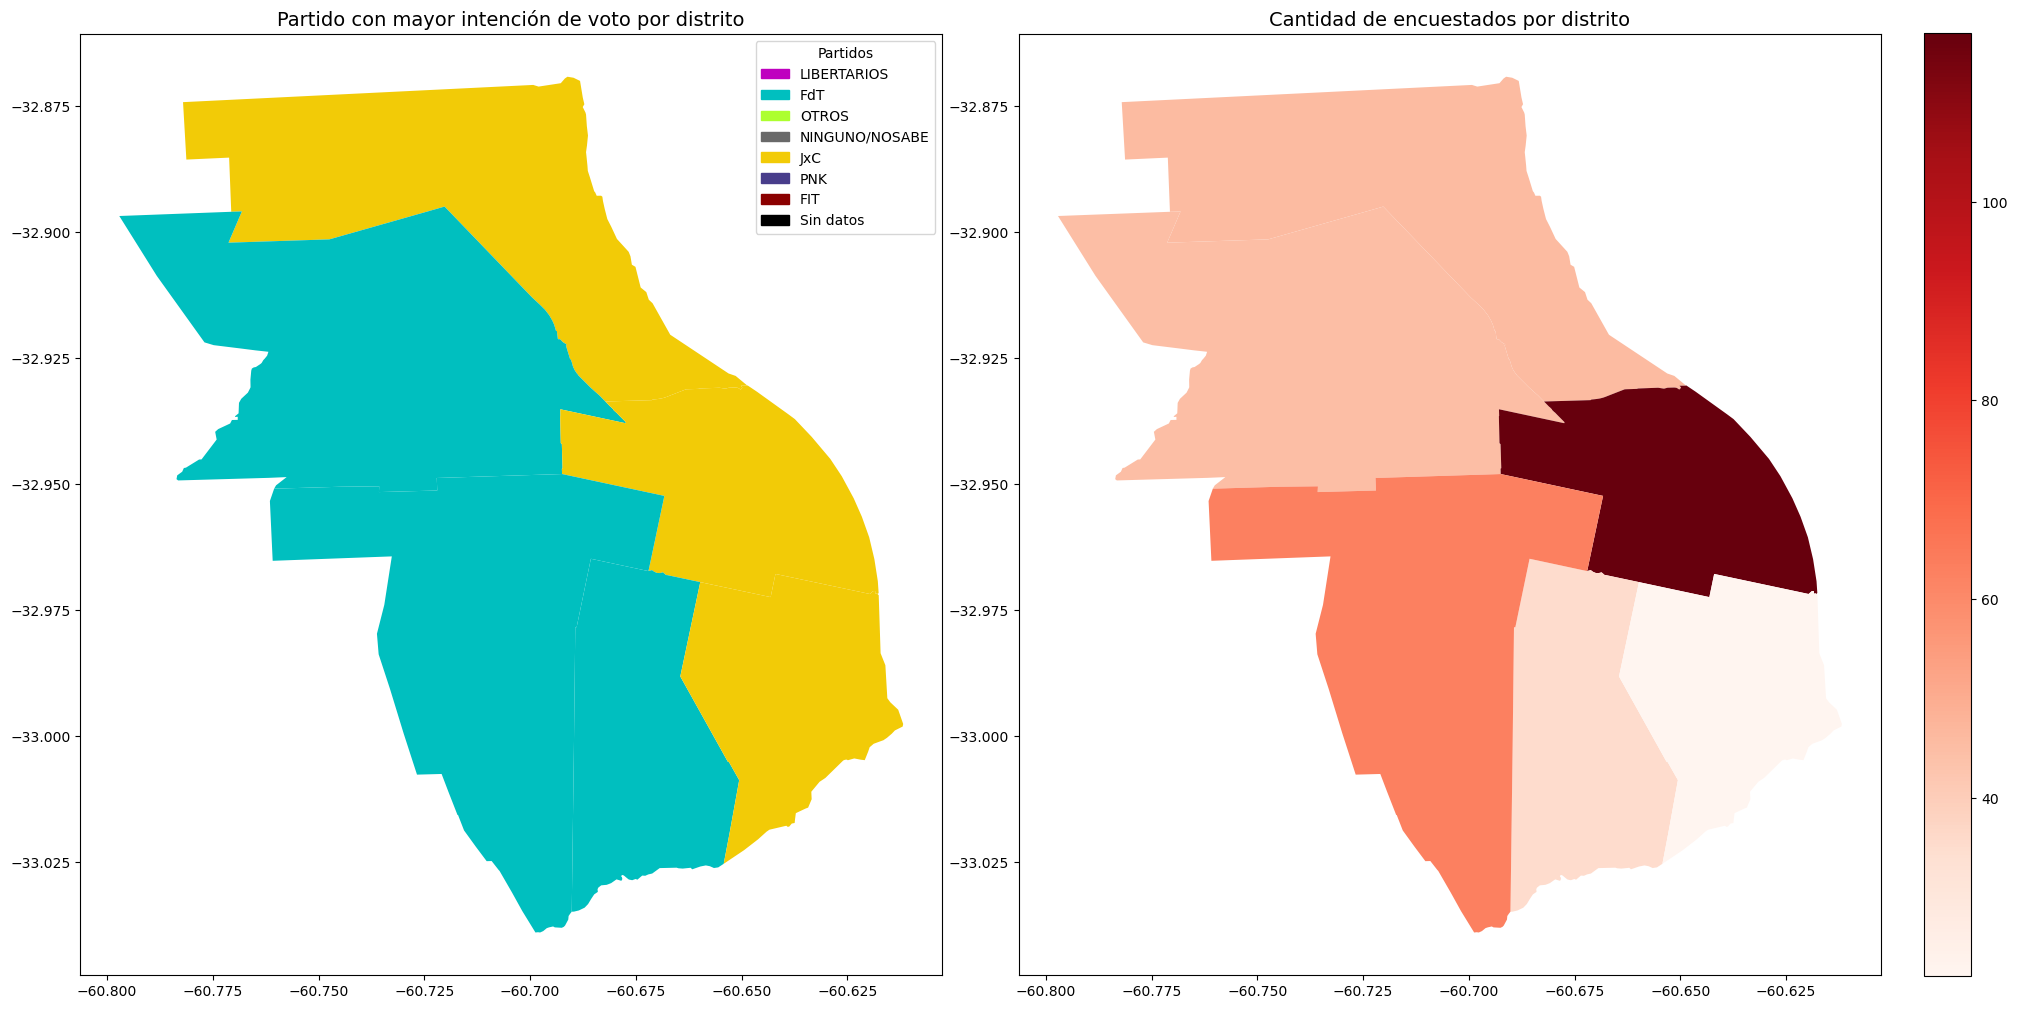

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10), constrained_layout=True)
distritos.plot(color=distritos['color'], ax=axes[0])
axes[0].set_title('Partido con mayor intención de voto por distrito', fontsize=14)
leyenda = [mpatches.Patch(color=color, label=partido) for partido, color in colores_partidos.items()]
leyenda.append(mpatches.Patch(color='black', label='Sin datos'))
axes[0].legend(handles=leyenda, title='Partidos', loc='upper right', fontsize=10)
distritos.plot(
    column='cantidad_votos', 
    cmap='Reds', 
    legend=True, 
    ax=axes[1],
    missing_kwds={
        "color": "lightgrey",
        "label": "Sin datos"}
)
axes[1].set_title('Cantidad de encuestados por distrito', fontsize=14)
plt.show()

In [13]:
conteo_votos = (
    unionseccion.groupby(['SECCION', 'INT DE VOTO X ESPACIO'])
    .size()
    .reset_index(name='conteo')
)
mayor_votos_por_seccion = conteo_votos.loc[conteo_votos.groupby('SECCION')['conteo'].idxmax()]
secciones = secciones.merge(mayor_votos_por_seccion, on='SECCION', how='left')
secciones['color'] = secciones['INT DE VOTO X ESPACIO'].map(colores_partidos).fillna('black')
conteo_votos_por_secciones = (
    unionseccion.groupby('SECCION')
    .size()
    .reset_index(name='cantidad_votos')
)
secciones = secciones.merge(conteo_votos_por_secciones, on='SECCION', how='left')

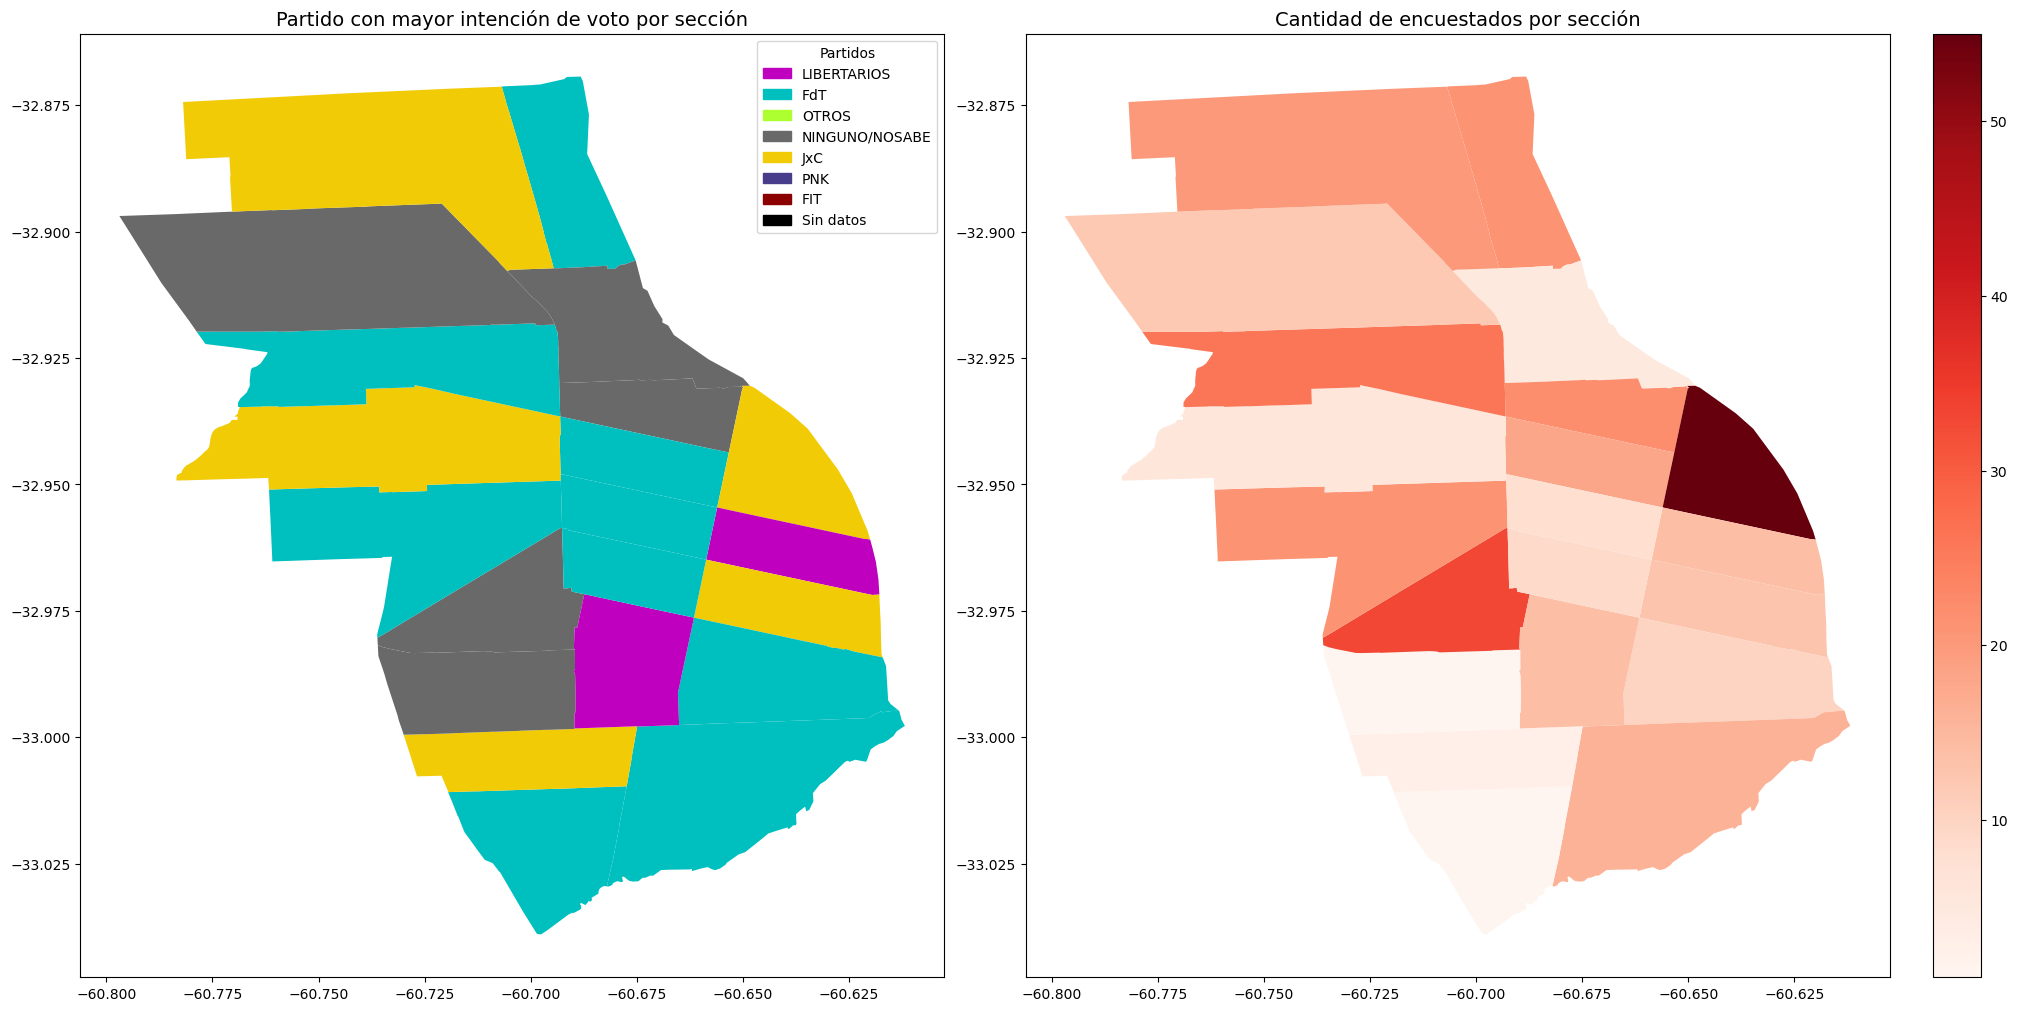

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10), constrained_layout=True)
secciones.plot(color=secciones['color'], ax=axes[0])
axes[0].set_title('Partido con mayor intención de voto por sección', fontsize=14)
leyenda = [mpatches.Patch(color=color, label=partido) for partido, color in colores_partidos.items()]
leyenda.append(mpatches.Patch(color='black', label='Sin datos'))
axes[0].legend(handles=leyenda, title='Partidos', loc='upper right', fontsize=10)
secciones.plot(
    column='cantidad_votos', 
    cmap='Reds', 
    legend=True, 
    ax=axes[1],
    missing_kwds={
        "color": "lightgrey",
        "label": "Sin datos"}
)
axes[1].set_title('Cantidad de encuestados por sección', fontsize=14)
plt.show()

Ahora se va a analizar partido por partido, comenzando por el Frente de Todos

In [15]:
gdf_votos_fdt=union[union['INT DE VOTO X ESPACIO']=='FdT']
conteo_votos_fdt = gdf_votos_fdt.groupby('BARRIO').size().reset_index(name='cantidad_votos_fdt')
barrios = barrios.merge(conteo_votos_fdt, on='BARRIO', how='left')

In [16]:
gdf_votos_fdt_dis=uniondistritos[uniondistritos['INT DE VOTO X ESPACIO']=='FdT']
conteo_votos_fdt_dis = gdf_votos_fdt_dis.groupby('DISTRITO').size().reset_index(name='cantidad_votos_fdt')
distritos = distritos.merge(conteo_votos_fdt_dis, on='DISTRITO', how='left')

In [17]:
gdf_votos_fdt_sec=unionseccion[unionseccion['INT DE VOTO X ESPACIO']=='FdT']
conteo_votos_fdt_sec = gdf_votos_fdt_sec.groupby('SECCION').size().reset_index(name='cantidad_votos_fdt')
secciones = secciones.merge(conteo_votos_fdt_sec, on='SECCION', how='left')

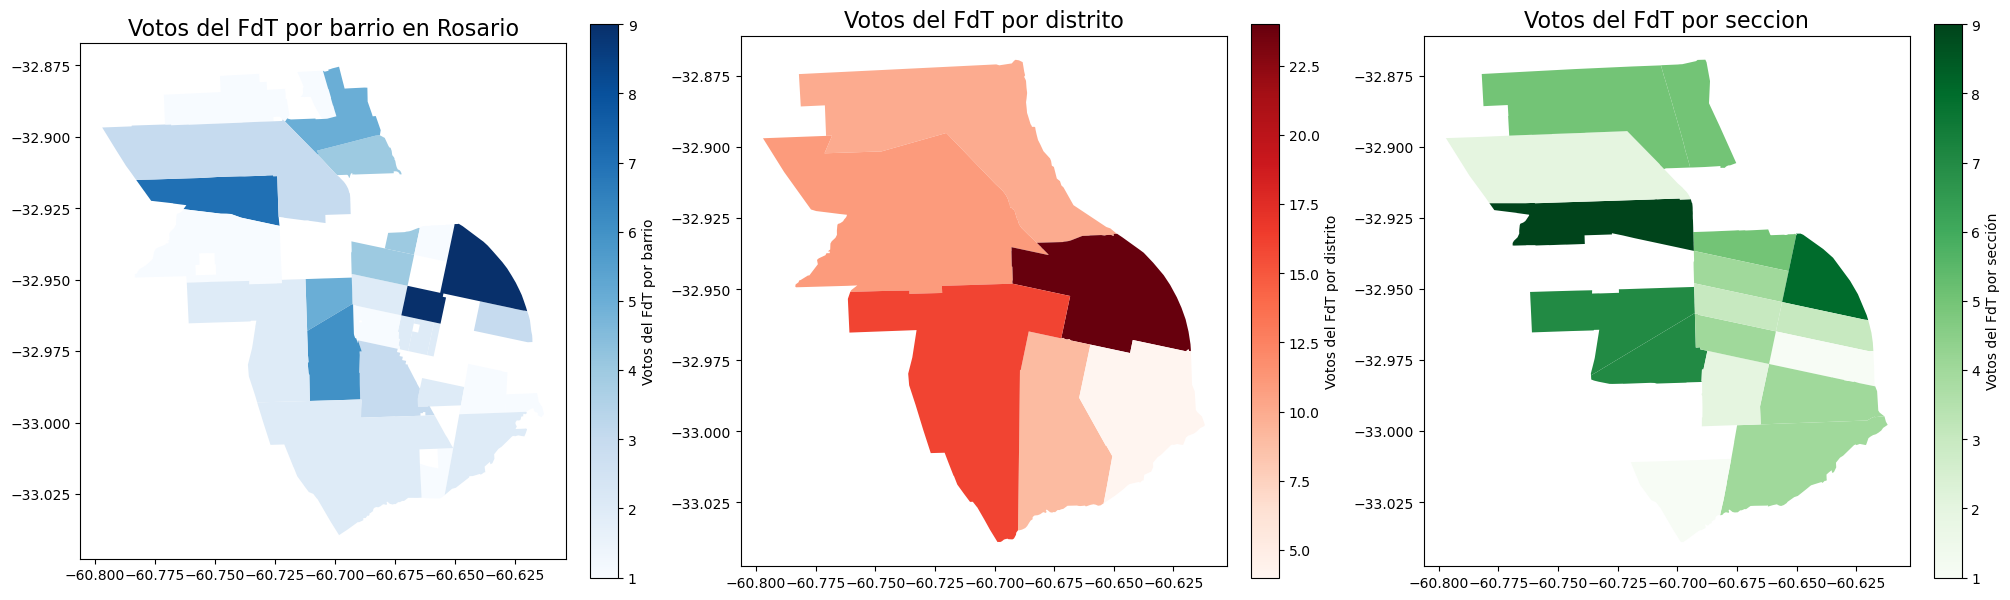

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7), constrained_layout=True)
barrios.plot(column='cantidad_votos_fdt', ax=axes[0], legend=True, cmap='Blues', legend_kwds={'label': "Votos del FdT por barrio",'shrink': 0.8})
axes[0].set_title('Votos del FdT por barrio en Rosario', fontsize=16)
distritos.plot(column='cantidad_votos_fdt', ax=axes[1], legend=True,cmap='Reds', legend_kwds={'label':'Votos del FdT por distrito', 'shrink': 0.8})
axes[1].set_title('Votos del FdT por distrito', fontsize=16)
secciones.plot(column='cantidad_votos_fdt', ax=axes[2], legend=True, cmap='Greens', legend_kwds={'label':'Votos del FdT por sección', 'shrink': 0.8})
axes[2].set_title('Votos del FdT por seccion', fontsize=16)
plt.show()

In [19]:
gdf_votos_jxc=union[union['INT DE VOTO X ESPACIO']=='JxC']
conteo_votos_jxc = gdf_votos_jxc.groupby('BARRIO').size().reset_index(name='cantidad_votos_jxc')
barrios = barrios.merge(conteo_votos_jxc, on='BARRIO', how='left')
gdf_votos_jxc_dis=uniondistritos[uniondistritos['INT DE VOTO X ESPACIO']=='JxC']
conteo_votos_jxc_dis = gdf_votos_jxc_dis.groupby('DISTRITO').size().reset_index(name='cantidad_votos_jxc')
distritos = distritos.merge(conteo_votos_jxc_dis, on='DISTRITO', how='left')
gdf_votos_jxc_sec=unionseccion[unionseccion['INT DE VOTO X ESPACIO']=='JxC']
conteo_votos_jxc_sec = gdf_votos_jxc_sec.groupby('SECCION').size().reset_index(name='cantidad_votos_jxc')
secciones = secciones.merge(conteo_votos_jxc_sec, on='SECCION', how='left')

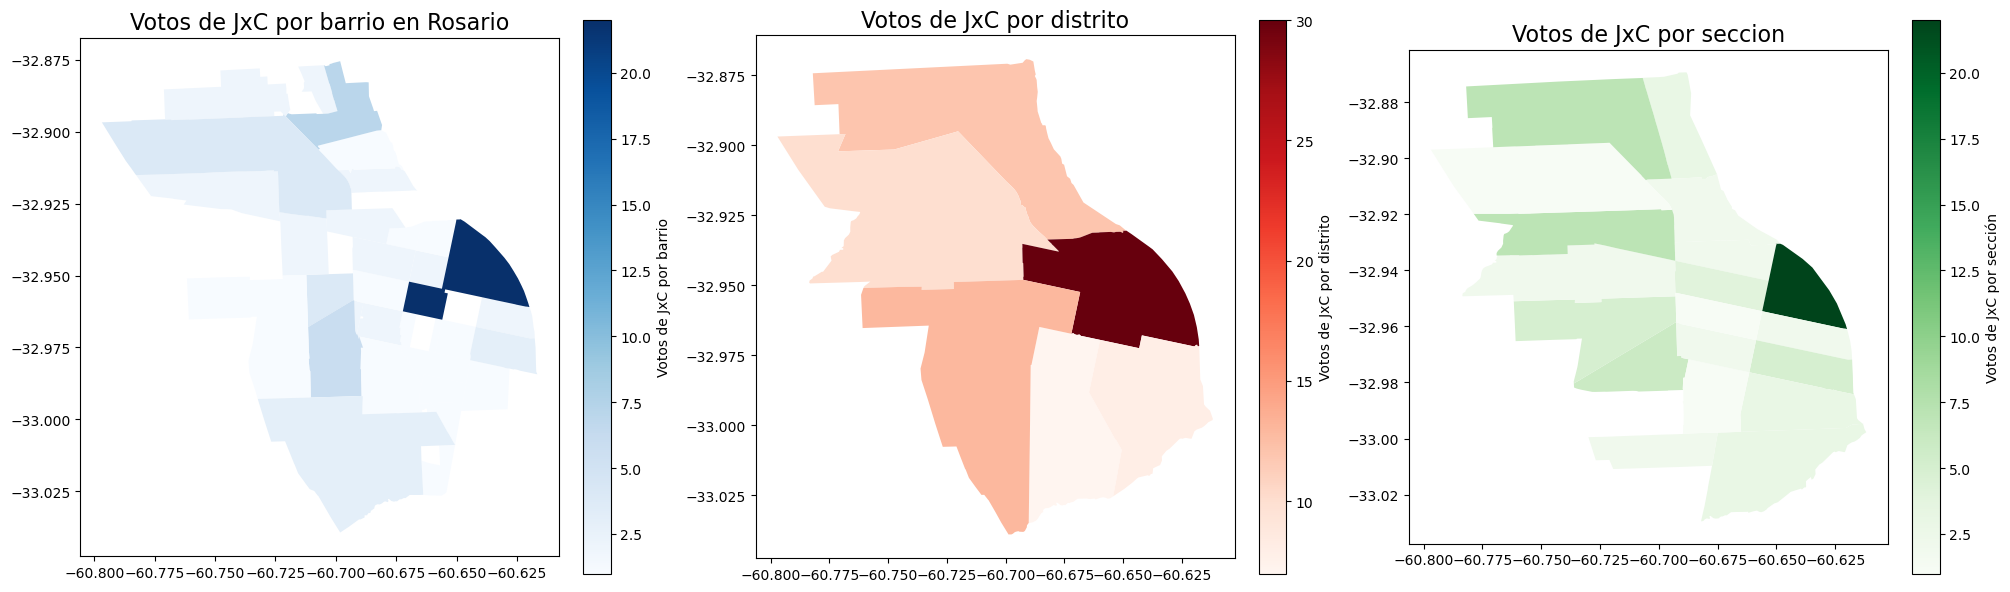

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7), constrained_layout=True)
barrios.plot(column='cantidad_votos_jxc', ax=axes[0], legend=True, cmap='Blues', legend_kwds={'label': "Votos de JxC por barrio", 'shrink': 0.8})
axes[0].set_title('Votos de JxC por barrio en Rosario', fontsize=16)
distritos.plot(column='cantidad_votos_jxc', ax=axes[1], legend=True,cmap='Reds', legend_kwds={'label':'Votos de JxC por distrito', 'shrink': 0.8})
axes[1].set_title('Votos de JxC por distrito', fontsize=16)
secciones.plot(column='cantidad_votos_jxc', ax=axes[2], legend=True, cmap='Greens', legend_kwds={'label':'Votos de JxC por sección', 'shrink': 0.8})
axes[2].set_title('Votos de JxC por seccion', fontsize=16)
plt.show()

In [21]:
gdf_votos_lib=union[union['INT DE VOTO X ESPACIO']=='LIBERTARIOS']
conteo_votos_lib = gdf_votos_lib.groupby('BARRIO').size().reset_index(name='cantidad_votos_lib')
barrios = barrios.merge(conteo_votos_lib, on='BARRIO', how='left')
gdf_votos_lib_dis=uniondistritos[uniondistritos['INT DE VOTO X ESPACIO']=='LIBERTARIOS']
conteo_votos_lib_dis = gdf_votos_lib_dis.groupby('DISTRITO').size().reset_index(name='cantidad_votos_lib')
distritos = distritos.merge(conteo_votos_lib_dis, on='DISTRITO', how='left')
gdf_votos_lib_sec=unionseccion[unionseccion['INT DE VOTO X ESPACIO']=='LIBERTARIOS']
conteo_votos_lib_sec = gdf_votos_lib_sec.groupby('SECCION').size().reset_index(name='cantidad_votos_lib')
secciones = secciones.merge(conteo_votos_lib_sec, on='SECCION', how='left')

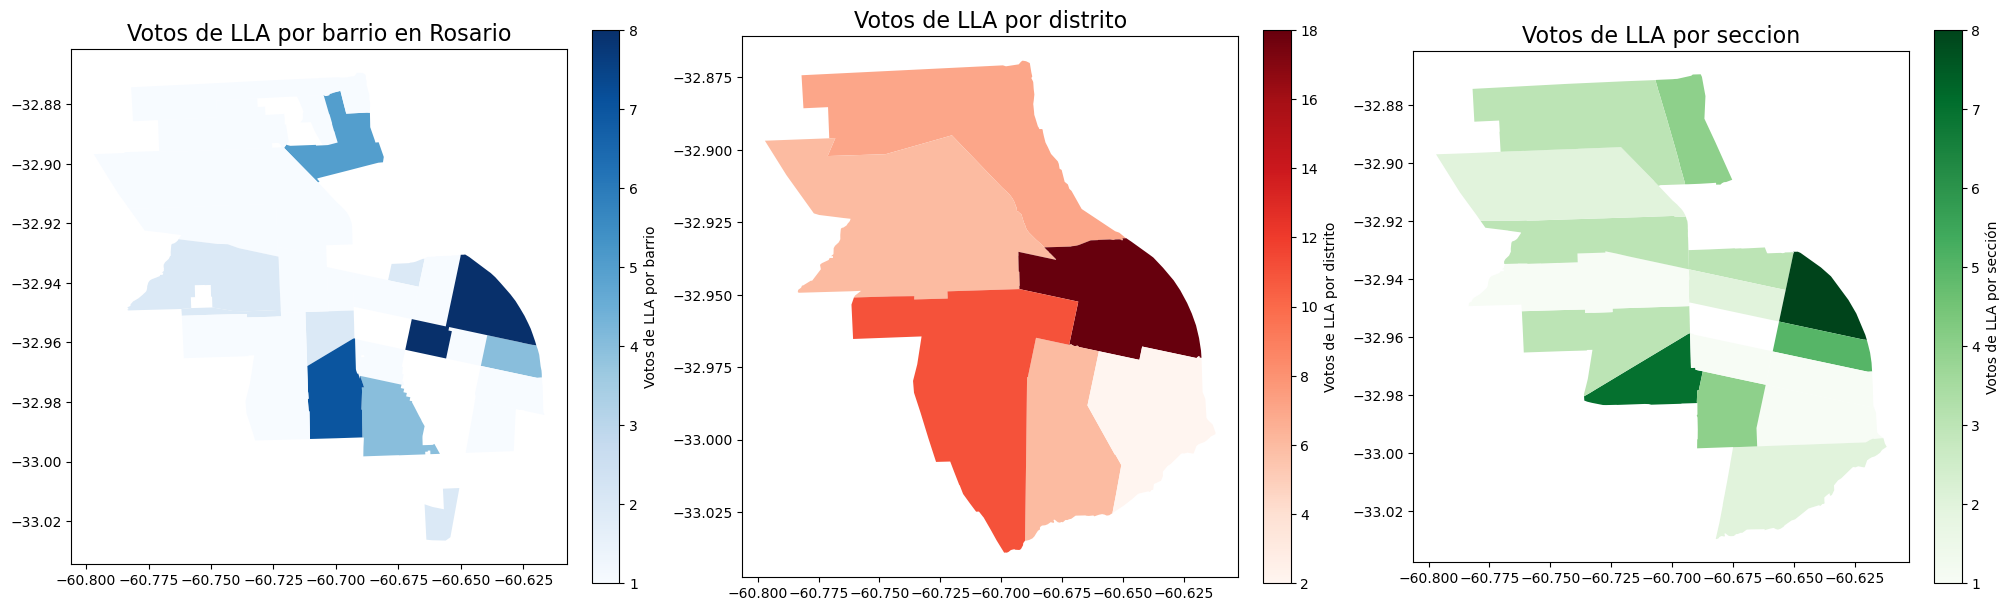

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7), constrained_layout=True)
barrios.plot(column='cantidad_votos_lib', ax=axes[0], legend=True, cmap='Blues', legend_kwds={'label': "Votos de LLA por barrio", 'shrink': 0.8})
axes[0].set_title('Votos de LLA por barrio en Rosario', fontsize=16)
distritos.plot(column='cantidad_votos_lib', ax=axes[1], legend=True,cmap='Reds', legend_kwds={'label':'Votos de LLA por distrito', 'shrink': 0.8})
axes[1].set_title('Votos de LLA por distrito', fontsize=16)
secciones.plot(column='cantidad_votos_lib', ax=axes[2], legend=True, cmap='Greens', legend_kwds={'label':'Votos de LLA por sección', 'shrink': 0.8})
axes[2].set_title('Votos de LLA por seccion', fontsize=16)
plt.show()

In [23]:
gdf_votos_fit=union[union['INT DE VOTO X ESPACIO']=='FIT']
conteo_votos_fit = gdf_votos_fit.groupby('BARRIO').size().reset_index(name='cantidad_votos_fit')
barrios = barrios.merge(conteo_votos_fit, on='BARRIO', how='left')
gdf_votos_fit_dis=uniondistritos[uniondistritos['INT DE VOTO X ESPACIO']=='FIT']
conteo_votos_fit_dis = gdf_votos_fit_dis.groupby('DISTRITO').size().reset_index(name='cantidad_votos_fit')
distritos = distritos.merge(conteo_votos_fit_dis, on='DISTRITO', how='left')
gdf_votos_fit_sec=unionseccion[unionseccion['INT DE VOTO X ESPACIO']=='FIT']
conteo_votos_fit_sec = gdf_votos_fit_sec.groupby('SECCION').size().reset_index(name='cantidad_votos_fit')
secciones = secciones.merge(conteo_votos_fit_sec, on='SECCION', how='left')

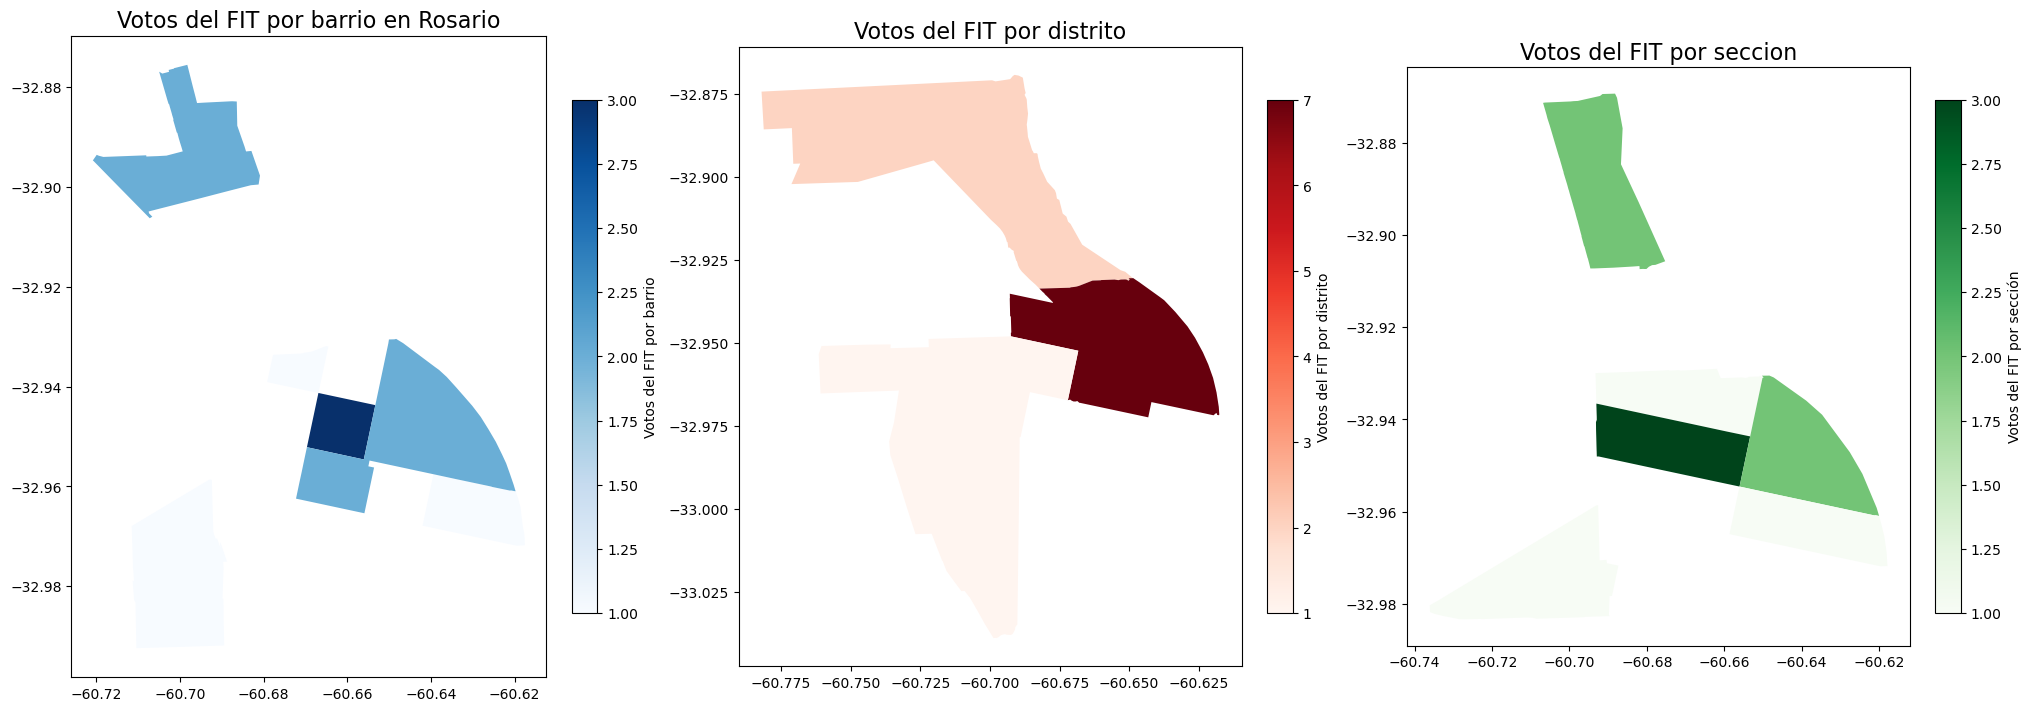

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7), constrained_layout=True)
barrios.plot(column='cantidad_votos_fit', ax=axes[0], legend=True, cmap='Blues', legend_kwds={'label': "Votos del FIT por barrio", 'shrink': 0.8})
axes[0].set_title('Votos del FIT por barrio en Rosario', fontsize=16)
distritos.plot(column='cantidad_votos_fit', ax=axes[1], legend=True,cmap='Reds', legend_kwds={'label':'Votos del FIT por distrito', 'shrink': 0.8})
axes[1].set_title('Votos del FIT por distrito', fontsize=16)
secciones.plot(column='cantidad_votos_fit', ax=axes[2], legend=True, cmap='Greens', legend_kwds={'label':'Votos del FIT por sección', 'shrink': 0.8})
axes[2].set_title('Votos del FIT por seccion', fontsize=16)
plt.show()

In [25]:
gdf_votos_pnk=union[union['INT DE VOTO X ESPACIO']=='PNK']
conteo_votos_pnk = gdf_votos_pnk.groupby('BARRIO').size().reset_index(name='cantidad_votos_pnk')
barrios = barrios.merge(conteo_votos_pnk, on='BARRIO', how='left')
gdf_votos_pnk_dis=uniondistritos[uniondistritos['INT DE VOTO X ESPACIO']=='PNK']
conteo_votos_pnk_dis = gdf_votos_pnk_dis.groupby('DISTRITO').size().reset_index(name='cantidad_votos_pnk')
distritos = distritos.merge(conteo_votos_pnk_dis, on='DISTRITO', how='left')
gdf_votos_pnk_sec=unionseccion[unionseccion['INT DE VOTO X ESPACIO']=='PNK']
conteo_votos_pnk_sec = gdf_votos_pnk_sec.groupby('SECCION').size().reset_index(name='cantidad_votos_pnk')
secciones = secciones.merge(conteo_votos_pnk_sec, on='SECCION', how='left')

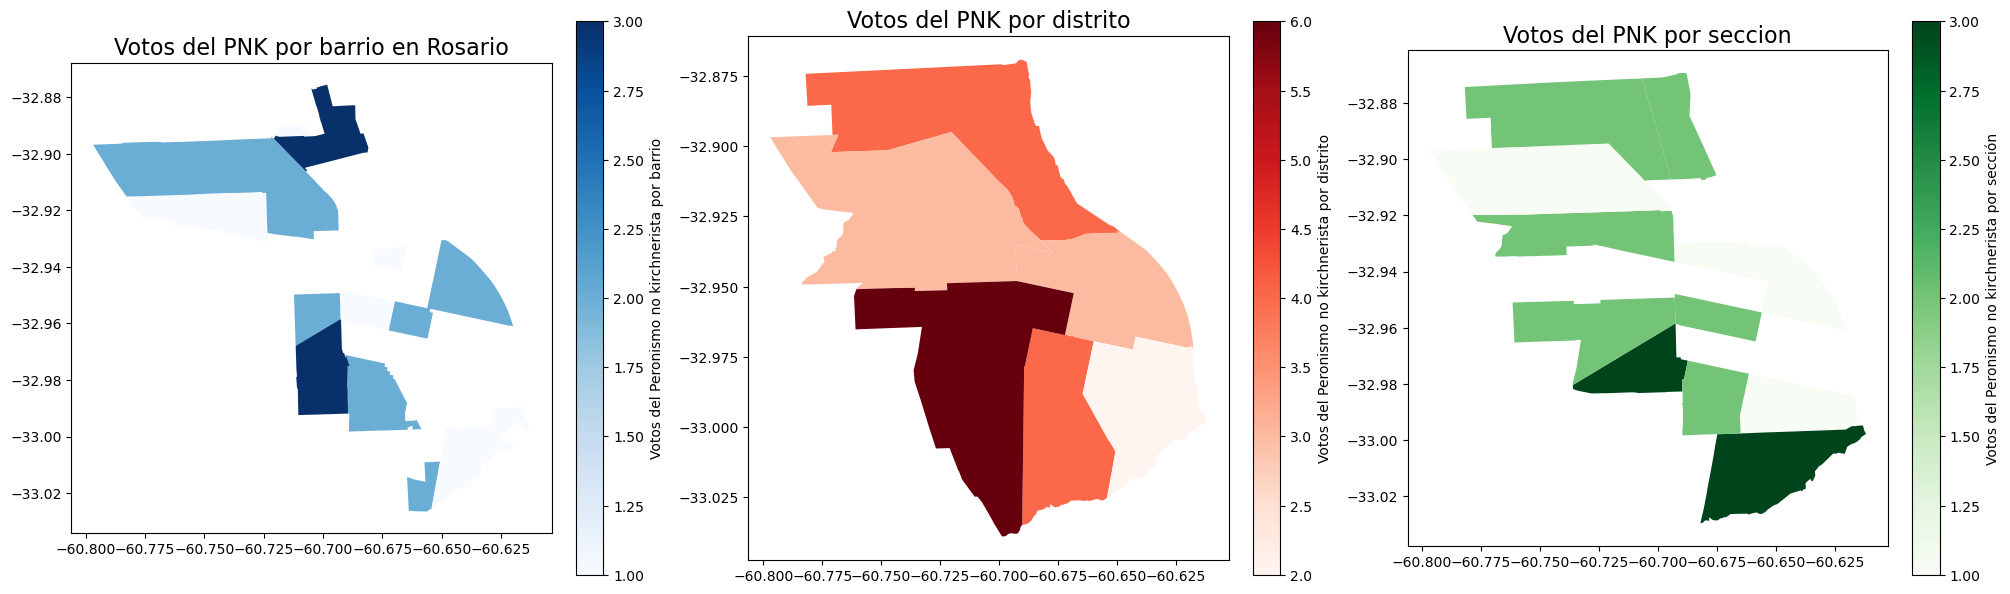

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7), constrained_layout=True)
barrios.plot(column='cantidad_votos_pnk', ax=axes[0], legend=True, cmap='Blues', legend_kwds={'label': "Votos del Peronismo no kirchnerista por barrio", 'shrink': 0.8})
axes[0].set_title('Votos del PNK por barrio en Rosario', fontsize=16)
distritos.plot(column='cantidad_votos_pnk', ax=axes[1], legend=True,cmap='Reds', legend_kwds={'label':'Votos del Peronismo no kirchnerista por distrito', 'shrink': 0.8})
axes[1].set_title('Votos del PNK por distrito', fontsize=16)
secciones.plot(column='cantidad_votos_pnk', ax=axes[2], legend=True, cmap='Greens', legend_kwds={'label':'Votos del Peronismo no kirchnerista por sección', 'shrink': 0.8})
axes[2].set_title('Votos del PNK por seccion', fontsize=16)
plt.show()

In [27]:
gdf_votos_ns=union[union['INT DE VOTO X ESPACIO']=='NINGUNO/NOSABE']
conteo_votos_ns = gdf_votos_ns.groupby('BARRIO').size().reset_index(name='cantidad_votos_ns')
barrios = barrios.merge(conteo_votos_ns, on='BARRIO', how='left')
gdf_votos_ns_dis=uniondistritos[uniondistritos['INT DE VOTO X ESPACIO']=='NINGUNO/NOSABE']
conteo_votos_ns_dis = gdf_votos_ns_dis.groupby('DISTRITO').size().reset_index(name='cantidad_votos_ns')
distritos = distritos.merge(conteo_votos_ns_dis, on='DISTRITO', how='left')
gdf_votos_ns_sec=unionseccion[unionseccion['INT DE VOTO X ESPACIO']=='NINGUNO/NOSABE']
conteo_votos_ns_sec = gdf_votos_ns_sec.groupby('SECCION').size().reset_index(name='cantidad_votos_ns')
secciones = secciones.merge(conteo_votos_ns_sec, on='SECCION', how='left')

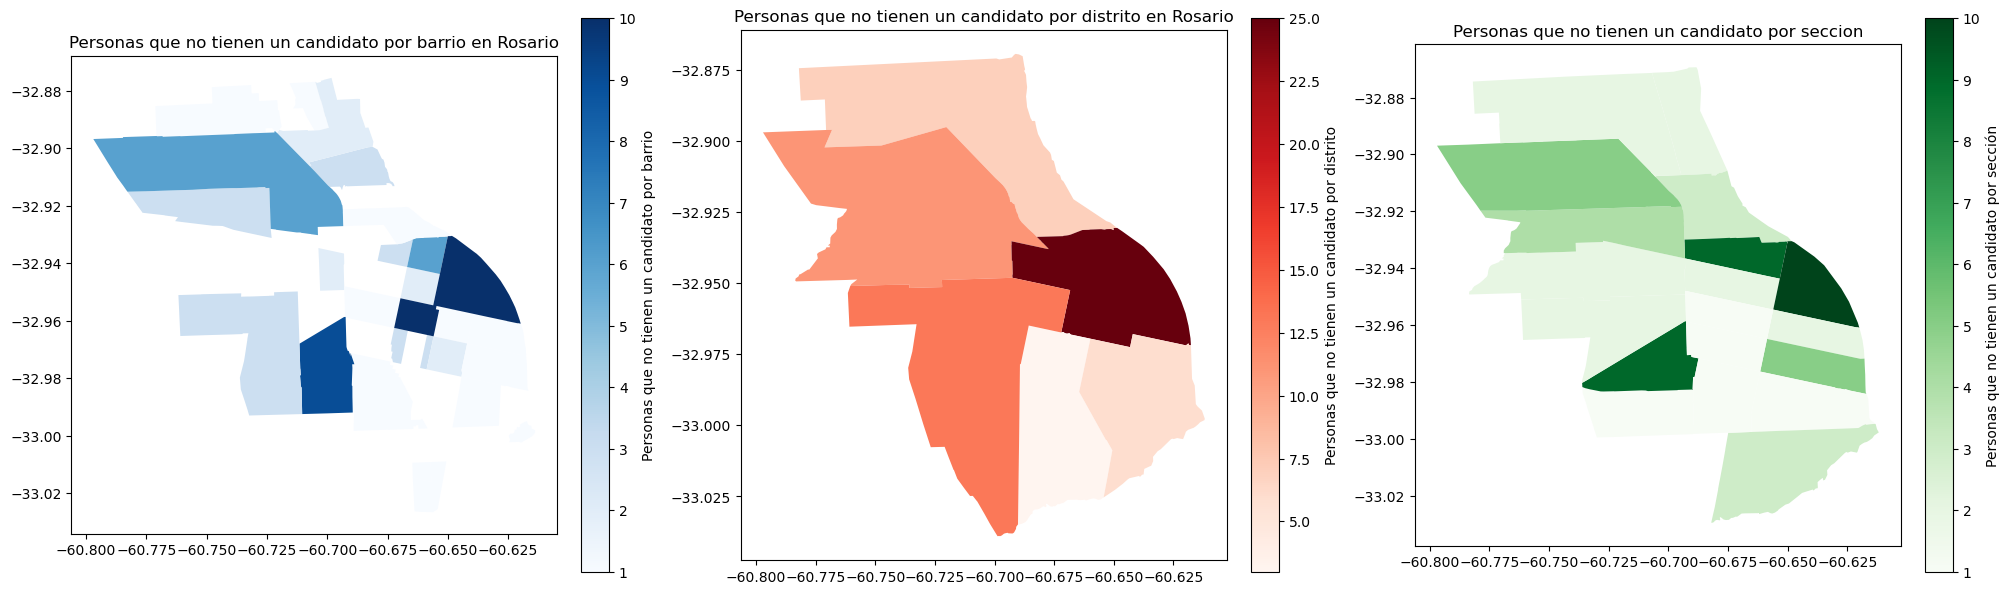

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7), constrained_layout=True)
barrios.plot(column='cantidad_votos_ns', ax=axes[0], legend=True, cmap='Blues', legend_kwds={'label': "Personas que no tienen un candidato por barrio", 'shrink': 0.8})
axes[0].set_title('Personas que no tienen un candidato por barrio en Rosario', fontsize=12)
distritos.plot(column='cantidad_votos_ns', ax=axes[1], legend=True,cmap='Reds', legend_kwds={'label':'Personas que no tienen un candidato por distrito', 'shrink': 0.8})
axes[1].set_title('Personas que no tienen un candidato por distrito en Rosario', fontsize=12)
secciones.plot(column='cantidad_votos_ns', ax=axes[2], legend=True, cmap='Greens', legend_kwds={'label':'Personas que no tienen un candidato por sección', 'shrink': 0.8})
axes[2].set_title('Personas que no tienen un candidato por seccion', fontsize=12)
plt.show()

In [29]:
gdf_votos_otros=union[union['INT DE VOTO X ESPACIO']=='OTROS']
conteo_votos_otros = gdf_votos_otros.groupby('BARRIO').size().reset_index(name='cantidad_votos_otros')
barrios = barrios.merge(conteo_votos_otros, on='BARRIO', how='left')
gdf_votos_otros_dis=uniondistritos[uniondistritos['INT DE VOTO X ESPACIO']=='OTROS']
conteo_votos_otros_dis = gdf_votos_otros_dis.groupby('DISTRITO').size().reset_index(name='cantidad_votos_otros')
distritos = distritos.merge(conteo_votos_otros_dis, on='DISTRITO', how='left')
gdf_votos_otros_sec=unionseccion[unionseccion['INT DE VOTO X ESPACIO']=='OTROS']
conteo_votos_otros_sec = gdf_votos_otros_sec.groupby('SECCION').size().reset_index(name='cantidad_votos_otros')
secciones = secciones.merge(conteo_votos_otros_sec, on='SECCION', how='left')

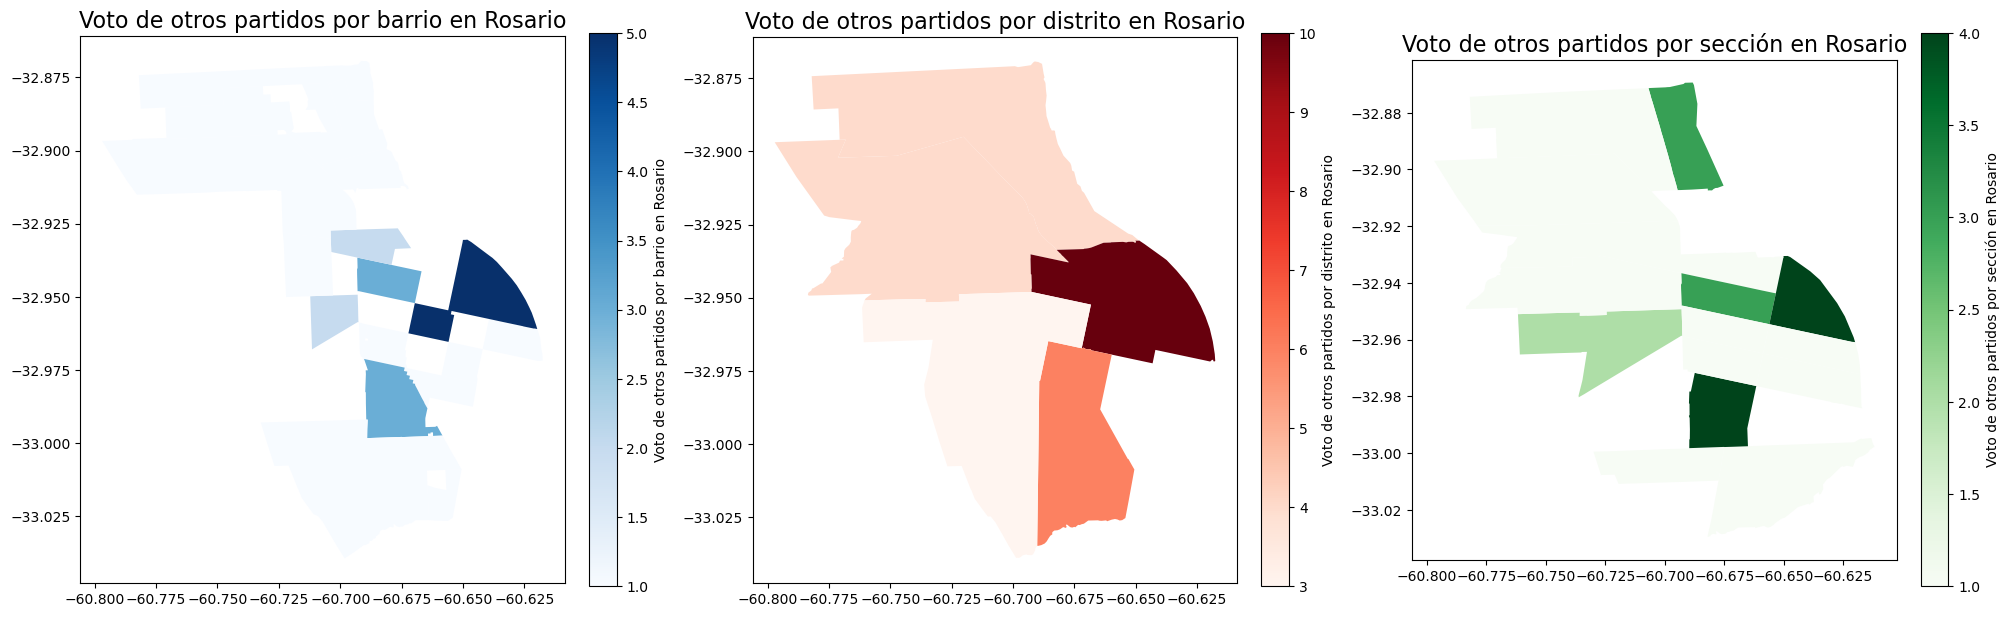

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7), constrained_layout=True)
barrios.plot(column='cantidad_votos_otros', ax=axes[0], legend=True, cmap='Blues', legend_kwds={'label': "Voto de otros partidos por barrio en Rosario", 'shrink': 0.8})
axes[0].set_title('Voto de otros partidos por barrio en Rosario', fontsize=16)
distritos.plot(column='cantidad_votos_otros', ax=axes[1], legend=True,cmap='Reds', legend_kwds={'label':'Voto de otros partidos por distrito en Rosario', 'shrink': 0.8})
axes[1].set_title('Voto de otros partidos por distrito en Rosario', fontsize=16)
secciones.plot(column='cantidad_votos_otros', ax=axes[2], legend=True, cmap='Greens', legend_kwds={'label':'Voto de otros partidos por sección en Rosario', 'shrink': 0.8})
axes[2].set_title('Voto de otros partidos por sección en Rosario', fontsize=16)
plt.show()

In [31]:
estratos['Geometría en GeoJSON'] = estratos['Geometría en GeoJSON'].apply(lambda x: shape(json.loads(x)))
estratos=estratos.set_geometry('Geometría en GeoJSON')
estratos=gpd.GeoDataFrame(estratos, geometry='Geometría en GeoJSON', crs='EPSG:4326')
estratos = estratos.dropna(subset=['Latitud del centroide', 'Longitud del centroide'])
estratos = estratos.dropna(subset=["Segmento socioeconómico del radio"])
estratos = estratos.dropna(subset=['Geometría en GeoJSON'])

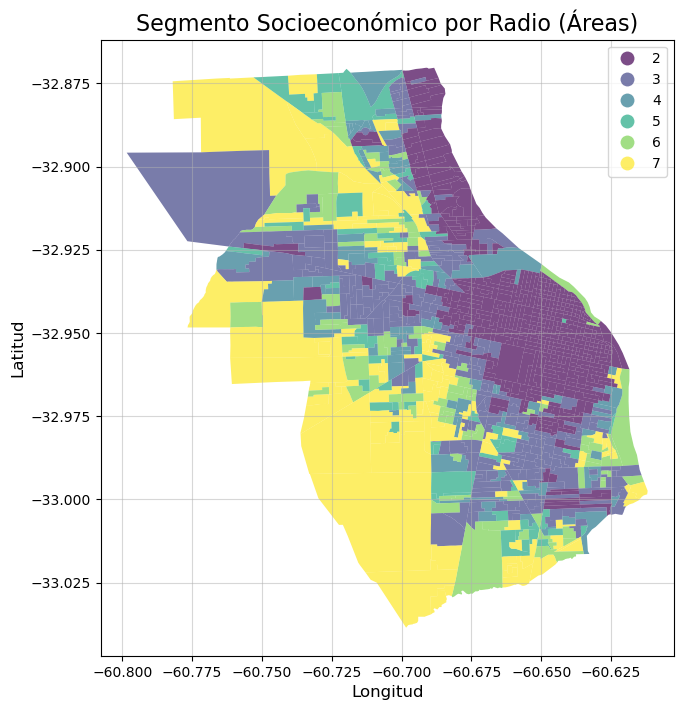

In [32]:
fig, ax = plt.subplots(figsize=(12, 8))
estratos.plot(column='Segmento socioeconómico del radio', ax=ax, legend=True, cmap='viridis', alpha=0.7)  # alpha controla la opacidad del área
ax.set_title('Segmento Socioeconómico por Radio (Áreas)', fontsize=16)
ax.set_xlabel('Longitud', fontsize=12)
ax.set_ylabel('Latitud', fontsize=12)
plt.grid(alpha=0.5)
plt.show()